In [1]:
import glob
import vaex
import dask

import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

from typing import List
from datetime import datetime
from numpy.linalg import inv, matrix_power 
from scipy.linalg import block_diag
from src.preprocessing import symmetrize_data, get_micro_adjustment

In [2]:
@dask.delayed
def extract_features(orderbook_file_path:str) -> pd.DataFrame:
    df = pd.read_csv(orderbook_file_path)[['timestamp', 'asks[0].price', 'bids[0].price', 'asks[0].amount', 'bids[0].amount']]
                           
   # calculate mid price and bidask spread
    df['mid_price'] = (df['asks[0].price'] + df['bids[0].price'])/2
    df['ba_spread'] = np.round((df['asks[0].price'] - df['bids[0].price']),2)
    df['imbalance'] = df['bids[0].amount']/(df['bids[0].amount'] + df['asks[0].amount'])
    df['timestamp'] = pd.to_datetime(df['timestamp']/1000, unit='ms')

    # convert timestamp to datetime format
    df = df[['timestamp','mid_price', 'ba_spread', 'imbalance']].set_index('timestamp')
    
    # resample by 1second frequency
    df = df.resample('1s').last().ffill()
    return df

@dask.delayed
def extract_features(orderbook_file_path:str) -> pd.DataFrame:
    df = pd.read_csv(orderbook_file_path)[['timestamp', 'asks[0].price', 'bids[0].price', 'asks[0].amount', 'bids[0].amount']]
                           
   # calculate mid price and bidask spread
    df['mid_price'] = (df['asks[0].price'] + df['bids[0].price'])/2
    df['ba_spread'] = np.round((df['asks[0].price'] - df['bids[0].price']),2)
    df['imbalance'] = df['bids[0].amount']/(df['bids[0].amount'] + df['asks[0].amount'])
    df['timestamp'] = pd.to_datetime(df['timestamp']/1000, unit='ms')

    # convert timestamp to datetime format
    df = df[['timestamp','mid_price', 'ba_spread', 'imbalance']].set_index('timestamp')
    
    # resample by 1second frequency
    df = df.resample('1s').last().ffill()
    return df

@dask.delayed
def extract_quotes(trade_file_path:str) -> pd.DataFrame:
    df = pd.read_csv(trade_file_path)[['timestamp', 'ask_price', 'bid_price', 'ask_amount', 'bid_amount']]
    df['timestamp'] = pd.to_datetime(df['timestamp']/1000, unit='ms')
    return df.set_index('timestamp')

@dask.delayed
def extract_trades(trade_file_path:str) -> pd.DataFrame:
    df = pd.read_csv(trade_file_path)[['timestamp', 'side', 'price', 'amount']]
    df['timestamp'] = pd.to_datetime(df['timestamp']/1000, unit='ms')
    return df.set_index('timestamp')

In [5]:
DATA_PATH = '/Users/mac/Desktop/Repos/FBD_Project/datasets/'
orderbook_list = sorted(glob.glob(DATA_PATH + 'btcusdt/orderbook/*.csv.gz'))
quote_list = sorted(glob.glob(DATA_PATH + 'btcusdt/quotes/*.csv.gz'))
trade_list = sorted(glob.glob(DATA_PATH + 'btcusdt/trades/*.csv.gz'))

In [4]:
# # process raw data to get features for calculation.
# %time
# trades = [extract_trades(path) for path in trade_list[:5]] 
# quotes = [extract_quotes(path) for path in quote_list[:5]] 

# df_trade = dask.compute(trades)[0]
# df_trade = pd.concat(df_trade)

# df_quote = dask.compute(quotes)[0]
# df_quote = pd.concat(df_quote)

# # join trade and quotes
# df_tq = pd.merge(df_quote.reset_index(), df_trade.reset_index(),how='outer', on='timestamp')
# df_tq = df_tq.set_index('timestamp').sort_index()

# df_tq['ba_spread'] = df_tq['ask_price'] - df_tq['bid_price']
# df_tq['imbalance'] = df_tq['bid_amount']/(df_tq['bid_amount'] + df_tq['ask_amount'])
# df_tq[['ba_spread', 'imbalance']] = df_tq[['ba_spread', 'imbalance']].ffill()

In [7]:
# process raw data to get features for calculation.
%time
all_features = [extract_features(path) for path in orderbook_list[:5]] 
df_feat = dask.compute(all_features)[0]
df_feat = pd.concat(df_feat)

# symmetrized data
df_sig = symmetrize_data(df_feat)
g1, B = get_micro_adjustment(df_sig)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 5.25 µs


/Users/mac/Desktop/Repos/FBD_Project/src/preprocessing.py:150: RuntimeWarning: invalid value encountered in divide
  J = np.nan_to_num(J / J.sum(axis=1).reshape(-1, 1), nan=0)
/Users/mac/Desktop/Repos/FBD_Project/src/preprocessing.py:183: RuntimeWarning: invalid value encountered in divide
  J2 = np.nan_to_num(J2 / J2.sum(axis=1).reshape(-1, 1), nan=0)


To do 
- check bidask imblaance and buy and sell volume (pre-trades only)
- eth, btc, ada spread distribution
- upgrade microprice prediction (bitcoin too much volatility)

In [101]:
df_feat['mid_chg'] = df_feat['mid_price'].diff()

In [112]:
df_feat[df_feat.mid_chg != 0].sort_values('mid_chg').iloc[:20]

,mid_price,ba_spread,imbalance,mid_chg
timestamp,,,,
2022-09-06 17:05:31,19462.20,5.6,0.009439,-130.80
2022-09-06 17:05:38,19274.90,58.8,0.367006,-103.15
2022-09-06 17:05:34,19384.95,4.5,0.037383,-76.35
2022-09-02 12:30:15,20106.70,13.4,0.767123,-72.80
2022-09-06 17:07:48,19150.05,0.1,0.999788,-64.60
2022-09-06 17:05:44,19190.15,14.3,0.001927,-60.60
2022-09-06 17:47:45,18984.90,0.2,0.011111,-52.15
2022-09-06 17:48:03,18933.05,0.1,0.996703,-49.80
2022-09-06 17:05:52,19163.75,32.7,0.698959,-47.45


<AxesSubplot: >

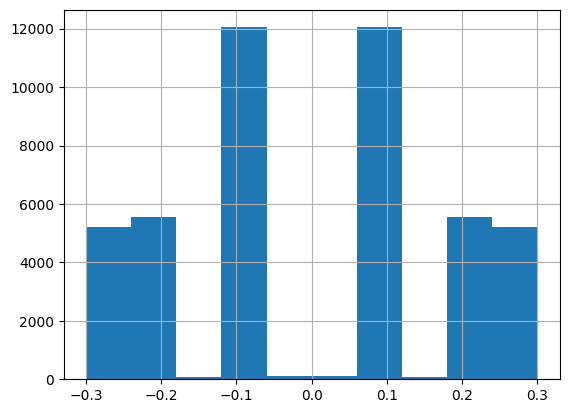

In [98]:
df_sig.mid_chg[df_sig.mid_chg != 0].hist()

In [16]:
micro_adj = g1 + np.linalg.matrix_power(B, 6) @  g1

In [21]:
df_feat.iloc[-1]

mid_price    18781.450000
ba_spread        0.100000
imbalance        0.631334
Name: 2022-09-06 23:59:59, dtype: float64

In [25]:
micro_adj.reshape(-1)

array([-0.00916065, -0.00239317,  0.00239317,  0.00916065, -0.01545455,
       -0.01363636,  0.01363636,  0.01545455, -0.03571429,  0.04675325,
       -0.04675325,  0.03571429,  0.05      ,  0.        ,  0.        ,
       -0.05      ])

In [23]:
micro_adj.max(), micro_adj.min()

(0.05000000244570758, -0.05000000244570758)